# Neural Nets Fun
### Using the classic MNIST data set to predict handwritten numbers and submitting to Kaggle

#### * I first built a simple Neural Network in Tf

#### * Then I did the same thing in Keras

#### * And finally I built a convolutional NN in Tf

---

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [3]:
%%time
data = pd.read_csv('train.csv')

X = data.drop(labels = 'label', axis = 1)
y = pd.get_dummies(data.label).values  #onehot encoded/getdummies

X_train, X_test, y_train, y_test = train_test_split(X,y)

# y_train = y_train.values.reshape(-1,1)
# y_test = y_test.values.reshape(-1,1)

#ss = StandardScaler() normalizing data by dividing by 255, not using StandardScaler
X_train = (X_train/255).values

X_test = (X_test/255).values



Wall time: 3.25 s


In [4]:
X_train.shape

(31500, 784)

In [5]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
y_train.shape

(31500, 10)

In [7]:
y_train 

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

## TensorFlow

In [6]:
#Construction phase
tf.reset_default_graph()

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 300
n_outputs = 10

X = tf.placeholder(dtype = tf.float32,
                   shape = (None, X_train.shape[1]),
                   name = 'X')
y = tf.placeholder(dtype = tf.float32,
                   shape = (None),
                   name = 'y')

hidden1 = tf.layers.dense(X, units = n_inputs,
                          name = 'hidden1',
                          activation = tf.nn.relu)

hidden2 = tf.layers.dense(hidden1, units = n_hidden1,
                          name = 'hidden2',
                          activation = tf.nn.relu)

y_hat = tf.layers.dense(hidden2, units = n_outputs,
                        name = 'y_hat',
                        activation = None)

loss = tf.losses.softmax_cross_entropy(y, y_hat)

optimizer = tf.train.AdamOptimizer(0.01)

training_op = optimizer.minimize(loss)

saver = tf.train.Saver()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [8]:
%%time
#execution phase
init = tf.global_variables_initializer()

test_err = []
train_err = []

with tf.Session() as sess:
    init.run()
    
    for epoch in range(100): #maybe add some minibatches so it converges faster
        sess.run(training_op,
                     feed_dict={X:X_train, y:y_train})
        
        train_loss = sess.run(loss, feed_dict={X:X_train, y:y_train})
        test_loss = sess.run(loss, feed_dict={X:X_test, y:y_test})
        
        test_err.append(test_loss)
        train_err.append(train_loss)
        
        if epoch % 20 == 0:
            print('epoch', epoch+1, train_loss, test_loss) #no need for the 'epoch+1', just epoch will suffice
        
    saver.save(sess,'./mnist.ckpt')
    pred = sess.run(y_hat, feed_dict={X:X_test})

epoch 1 2.9421973 2.9191291
epoch 21 0.2016079 0.23726042
epoch 41 0.0801494 0.14312345
epoch 61 0.031421117 0.12578337
epoch 81 0.0105531085 0.13486353
Wall time: 1min 43s


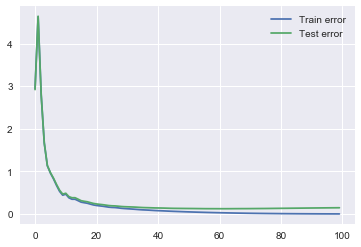

In [9]:
plt.plot(train_err, label='Train error')
plt.plot(test_err, label='Test error')
plt.legend()

In [10]:
predictions = np.argmax(pred, axis=1)

In [11]:
predictions.shape

(10500,)

In [12]:
y_true = np.argmax(y_test, axis=1)
y_true.shape

(10500,)

In [13]:
metrics.accuracy_score(y_true, predictions) #.971, not bad. 

0.9689523809523809

#### Lets make some predictions on the kaggle test data 

In [14]:
kaggle = pd.read_csv('test.csv')
kaggle.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
kaggle.shape

(28000, 784)

In [16]:
kaggle = (kaggle/255).values
kaggle.shape

(28000, 784)

In [17]:
with tf.Session() as sess:
    saver.restore(sess, './mnist.ckpt')
    predictions = sess.run(y_hat, feed_dict={X:kaggle})

INFO:tensorflow:Restoring parameters from ./mnist.ckpt


In [18]:
kaggle_preds = np.argmax(predictions, axis=1)
kg = pd.DataFrame(kaggle_preds, index = (range(len(predictions)))).rename(columns = {'index':'ImageId', 0:'Label'})
kg.index = kg.index + 1
# .to_csv('./kaggle_preds.csv', index = None)
kg.reset_index().rename(columns = {'index':'ImageID'}).to_csv('./kaggle_preds.csv', index = None)

## Keras <span style="color:red">  </span>


In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam


Using TensorFlow backend.


In [20]:
model = Sequential()

n_input = X_train.shape[1]
n_hidden = n_input
n_output = 10

model.add(Dense(n_hidden, input_dim=n_input, activation='relu'))
model.add(Dense(n_output, activation='softmax'))



In [21]:
adam = Adam(lr=0.001)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [22]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=20, batch_size=None, verbose=1)


Train on 31500 samples, validate on 10500 samples
Epoch 1/20
31500/31500 [==============================] - 15s 479us/step - loss: 0.2422 - acc: 0.9266 - val_loss: 0.1562 - val_acc: 0.9519

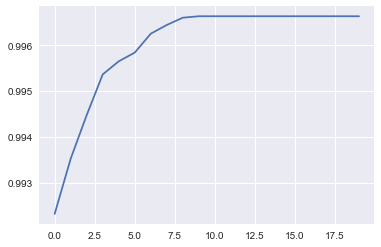

In [34]:
plt.plot(history.history['acc'])

In [35]:
history.history['acc'][-1]

0.9966349206349207

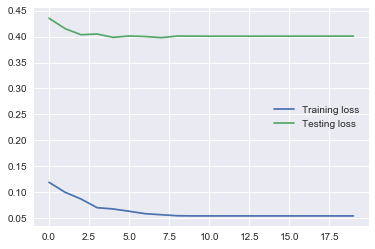

In [36]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()



### <span style="color:red">it seems like our model is not converging aka not learning. 

probably has too much bias, lets try making our model more complex, adding another hidden layer like we did in the tf example above </span>

# Keras w/ 2 hidden layers

In [49]:
y_test.shape

(10500, 10)

In [56]:
model_2 = Sequential()

n_input_2 = X_train.shape[1]
n_hidden_2 = n_input
n_output_2 = 10

model_2.add(Dense(n_hidden_2, input_dim=n_input, activation='relu'))
model_2.add(Dense(n_hidden_2, activation='relu'))
model_2.add(Dense(n_output_2, activation='softmax'))


In [57]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
history_2 = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=10, batch_size=32, verbose=1)

Train on 31500 samples, validate on 10500 samples
Epoch 1/10
31500/31500 [==============================] - 28s 903us/step - loss: 0.2302 - acc: 0.9278 - val_loss: 0.1523 - val_acc: 0.9560

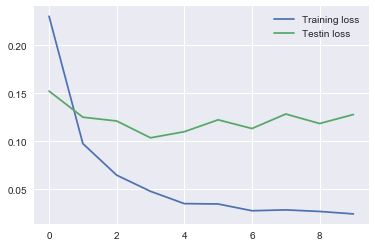

In [59]:
# train_loss = history_2.history['loss']
# test_loss = history_2.history['val_loss']
# plt.plot(train_loss, label='Training loss')
# plt.plot(test_loss, label='Testing loss')
# plt.legend()

plt.plot(history_2.history['loss'], label = 'Training loss')
plt.plot(history_2.history['val_loss'], label = 'Testin loss')
plt.legend()

# Looks like my learning rate is too large, I would try and decrease my learning rate, however keras doesn't play well with my machine

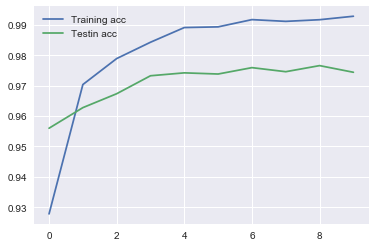

In [60]:
plt.plot(history_2.history['acc'], label = 'Training acc')
plt.plot(history_2.history['val_acc'], label = 'Testin acc')
plt.legend()



# TensorFlow convulted neural network

In [54]:
X_train[0].reshape(28,28,1)

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

In [12]:

tf.reset_default_graph()



X = tf.placeholder(dtype = tf.float32,
                   shape = (None, X_train.shape[1]),
                   name = 'X')
y = tf.placeholder(dtype = tf.float32,
                   shape = (None),
                   name = 'y')

# Input Layer
input_layer = tf.reshape(X, [-1, 28, 28, 1]) #we have to reshape since convultional2d layer wants the dimensions of our
                                             # image, which is 28 x 28 x 1(grayscale is 1, if rgb then 3 is 28 x 28 x 3)
                         
# Convolutional Layer #1
conv1 = tf.layers.conv2d(inputs=input_layer,filters=4,
                         kernel_size=[2, 2],
                         padding="same",
                         activation=tf.nn.relu)
    
# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1,
                                pool_size=[2, 2],##14 x 14, strides = 2 so our image is compressed from 28 --> 14
                                    strides=2)
                                    
# Convolutional Layer #2 and Pooling Layer #2
conv2 = tf.layers.conv2d(inputs=pool1,filters=8,
                         kernel_size=[2, 2],
                         padding="same",
                         activation=tf.nn.relu)
    
pool2 = tf.layers.max_pooling2d(inputs=conv2,
                                pool_size=[2, 2],#7x7 14 -- >7
                                strides=2)
# Dense Layer
pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 8])
    
dense = tf.layers.dense(inputs=pool2_flat, units=100, activation=tf.nn.relu)

dropout = tf.layers.dropout(inputs=dense,
                            rate=0.4)#40% to zero
# Logits Layer
y_hat = tf.layers.dense(inputs=dropout, units=10,
                        activation = None)

loss = tf.losses.softmax_cross_entropy(y, y_hat)

optimizer = tf.train.AdamOptimizer(0.01)

training_op = optimizer.minimize(loss)

saver = tf.train.Saver()

In [13]:
from sklearn.model_selection import train_test_split, KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)

batches = [train for train,_  in kf.split(X_train, y_train)]

In [14]:
%%time
#execution phase

init = tf.global_variables_initializer()

test_err = []
train_err = []

with tf.Session() as sess:
    init.run()
    
    for epoch in range(100): #maybe add some minibatches so it converges faster
        for batch in batches:
            X_batch = X_train[batch]
            y_batch = y_train[batch]
            sess.run(training_op,
                     feed_dict={X:X_batch, y:y_batch})
        
        train_loss = sess.run(loss, feed_dict={X:X_train, y:y_train})
        test_loss = sess.run(loss, feed_dict={X:X_test, y:y_test})
        
        test_err.append(test_loss)
        train_err.append(train_loss)
        
        if epoch % 20 == 0:
            print('epoch', epoch+1, train_loss, test_loss) #no need for the 'epoch+1', just epoch will suffice
        
    saver.save(sess,'./cnn_mnist.ckpt')
    pred = sess.run(y_hat, feed_dict={X:X_test})

epoch 1 1.7374498 1.7418187
epoch 21 0.103271134 0.1128223
epoch 41 0.04815109 0.071780875
epoch 61 0.02825593 0.06709547
epoch 81 0.016995348 0.07096462
Wall time: 16min 53s


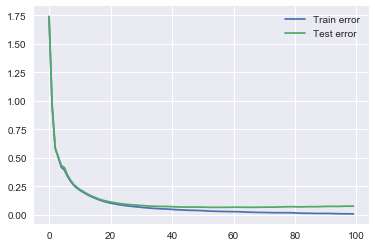

In [15]:
plt.plot(train_err, label='Train error')
plt.plot(test_err, label='Test error')
plt.legend()

In [16]:
predictions = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)
metrics.accuracy_score(y_true, predictions)

0.9801904761904762

In [18]:
kaggle = pd.read_csv('test.csv')
kaggle = (kaggle/255).values

with tf.Session() as sess:
    saver.restore(sess, './cnn_mnist.ckpt')
    predictions = sess.run(y_hat, feed_dict={X:kaggle})
    
kaggle_preds = np.argmax(predictions, axis=1)
kg = pd.DataFrame(kaggle_preds, index = (range(len(predictions)))).rename(columns = {'index':'ImageId', 0:'Label'})
kg.index = kg.index + 1
# .to_csv('./kaggle_preds.csv', index = None)
kg.reset_index().rename(columns = {'index':'ImageID'}).to_csv('./cnn_kaggle_preds.csv', index = None)

INFO:tensorflow:Restoring parameters from ./cnn_mnist.ckpt


## My second submission to kaggle scored:
Your Best Entry

You advanced 190 places on the leaderboard!
Your submission scored 0.97471, which is an improvement of your previous score of 0.96757. Great job!

#### <span style="color:blue"> Not bad without any feature engineering, to improve on this score I would feature engineer by shifting each image up left right and down a few pixels, also i would institute early stopping in my CNN </span>

In [17]:
# from tensorflow.python.client import device_lib

# device_lib.list_local_devices()